TODO

- Predict MPF from forwarded SIRs
- Compare un-forwarded and forwarded SIRs

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import xarray as xr
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
import os.path
import h5py as h5
from scipy.spatial import KDTree
import pyproj
from geopy.distance import geodesic


Set the `YEAR` to forward. Advection will start from `START_DATE` (currently 15th April of the year specified).
Set the `SPACING`, i.e. the spacing of points in the grid to be forwarded. `SPACING=100` will forward every 100th grid point. Set `SPACING=1` to forward every grid point.
Set the number of `DAYS_TO_FORWARD`.

In [125]:
YEAR = 2020
START_DATE = f'{YEAR}-04-01 12:00:00'
SPACING = 250
DAYS_TO_FORWARD = 153


### Inspect ice drift data files

Example file:

In [126]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc


Look at example file:

In [127]:
! ncdump -h /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

netcdf ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200 {
dimensions:
	time = 1 ;
	nv = 2 ;
	xc = 119 ;
	yc = 177 ;
variables:
	int Polar_Stereographic_Grid ;
		Polar_Stereographic_Grid:grid_mapping_name = "polar_stereographic" ;
		Polar_Stereographic_Grid:straight_vertical_longitude_from_pole = -45.f ;
		Polar_Stereographic_Grid:latitude_of_projection_origin = 90.f ;
		Polar_Stereographic_Grid:standard_parallel = 70.f ;
		Polar_Stereographic_Grid:false_easting = 0.f ;
		Polar_Stereographic_Grid:false_northing = 0.f ;
		Polar_Stereographic_Grid:semi_major_axis = 6378273.f ;
		Polar_Stereographic_Grid:semi_minor_axis = 6356890.f ;
		Polar_Stereographic_Grid:proj4_string = "+proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45" ;
	double time(time) ;
		time:axis = "T" ;
		time:long_name = "reference time of product" ;
		time:standard_name = "time" ;
		time:units = "seconds since 1978-01-01 00:00:00" ;
		time:calendar = "standard" ;
		time:bounds = "time_bnds

Available years: (2009 and 2024 are incomplete)

In [128]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/


2009  2011  2013  2015	2017  2019  2021  2023
2010  2012  2014  2016	2018  2020  2022  2024


In [129]:
# load the example file
#OSISAFfile = '/Users/micheltsamados/Google Drive/ADMINISTRATION/MosaicNERC2018/FieldTrip/WORK/DriftRackow/drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201708301200-201709011200.nc'
OSISAFfile = '/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc'
fl = Dataset(OSISAFfile)
#xc=fl.variables['xc']
#yc=fl.variables['yc']
#XC,YC=np.meshgrid(xc,yc)

# lon lat on grid
lon_start=np.copy(fl.variables['lon'])
lat_start=np.copy(fl.variables['lat'])

# lon lat at the end of the displacement
lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
lat_end=np.squeeze(fl.variables['lat1'][0,:,:])

# max and min start and end coords
lon_end.min(), lon_end.max(), lon_start.min(), lon_start.max()


(-179.70926, 179.05727, -180.0, 179.52649)

### Load class and functions

In [130]:
class Buoys:
    
    global rad, r_earth
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date):
        print(lon_start)
        self.oldlon = lon_start * rad
        self.oldlat = lat_start * rad
        self.lon = lon_start * rad
        self.lat = lat_start * rad
        self.initlon = lon_start * rad
        self.initlat = lat_start * rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        #self.delta_x = np.zeros(lon_start.shape)
        #self.delta_y = np.zeros(lon_start.shape)
        #self.u_ice = np.zeros(lon_start.shape)
        #self.v_ice = np.zeros(lon_start.shape)
        
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
        
    def trajectory(self, new_u, new_v, delta_t):
        print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg = self.lon/rad % 360
        lat_deg = np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        #idx=getindices_beforestart(self.getdate(), self.startdates)
        #lon_deg[idx] = np.nan
        #lat_deg[idx] = np.nan
        #self.lon[idx] = self.initlon[idx]
        #self.lat[idx] = self.initlat[idx]
        #self.old_u[idx]=0.
        #self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg


In [131]:
r_earth=6.3675*10**6 # radius of Earth in [m]
rad=np.pi/180.0 # radiant <-> degree

# a useful function we'll need
def length_of_latitude_circle(lat=85.):
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km


# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(startdates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices


# load OSISAF data for Northern Hemisphere at a certain date
def loaddate_ofOSISAF(datestring, hemisphere='nh'):
    
    # convert datestring to datetime object
    thedate = datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S")
    
    # let's construct the file name, 
    # e.g. drift-velocities/archive/ice/drift_lr/merged/2019/09/
    # ice_drift_nh_polstere-625_multi-oi_201909011200-201909031200.nc
    pathtofile = "/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/"
    # middle part
    middlefilename="ice_drift_"+hemisphere+"_polstere-625_multi-oi_"
    # e.g. 201907291200-201907311200 (48hr span)
    enddate=thedate + timedelta(days=2)
    # YYYY/MM/ (from end date)
    YYYYMM=enddate.strftime("%Y")+"/"+enddate.strftime("%m")+"/"
    endfilename= thedate.strftime("%Y%m%d%H%M") + "-" + enddate.strftime("%Y%m%d%H%M") + '.nc'
    
    # the OSISAF file to be loaded
    filename=pathtofile + YYYYMM + middlefilename + endfilename
    
    # take previous files in case there is a data gap
    sd=thedate
    ed=enddate
    while os.path.isfile(filename)!=True:
        # try previous file
        sd=sd - timedelta(days=1)
        ed=ed - timedelta(days=1)
        # YYYY/MM/ (from end date)
        YYYYMM=ed.strftime("%Y")+"/"+ed.strftime("%m")+"/"
        endfilename= sd.strftime("%Y%m%d%H%M") + "-" + ed.strftime("%Y%m%d%H%M") + '.nc'
        filename=pathtofile + YYYYMM + middlefilename + endfilename
        print('data gap: try previous file '+filename+' ...')
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)
    #xc=fl.variables['xc']
    #yc=fl.variables['yc']
    #XC,YC=np.meshgrid(xc,yc)
    
    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])

    # lon lat at the end of the displacement
    lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
    lat_end=np.squeeze(fl.variables['lat1'][0,:,:])
    
    # close the file
    fl.close()
    
    # compute Ufield from end points and start points (48hour change)
    deltalon=lon_end-lon_start
    deltalon[deltalon>100.]=deltalon[deltalon>100.]-360.   # jump at -180..180
    deltalon[deltalon<-100.]=deltalon[deltalon<-100.]+360. # jump at -180..180
    Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. / 3.6 # km/h -> m/s
    
    # compute Vfield as well
    Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. / 3.6 #km/h -> m/s
    
    return Ufield, Vfield, lon_start, lat_start


# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(lon_start,lat_start, Ufield,Vfield, objects):
    
    # (lon,lat) tuples of the underlying grid
    A = np.array([lon_start[:,:].flatten(), lat_start[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    lon_adjust = objects.lon/rad
    lon_adjust[lon_adjust>180.] = lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((lon_adjust, objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx = spatial.KDTree(A).query(tuples)[1]
    
    return Ufield[idx], Vfield[idx]


def WGS84toEASE2N(lon, lat):
    '''Converts WGS84 coordinates to EASE2N.

    Params:
        lon (array): the WGS84 longitude to convert
        lat (array): the WGS84 latitude to convert

    Returns:
        (x, y): the corresponding EASE2N x and y coordinates
    '''

    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


def load_MISR(MISR_path):
    '''Loads MISR data and coordinates from specified file path.

    Params:
        MISR_path (str): the file path from which to retrieve data

    Returns:
        data (np.array): roughness data retrieved from the specified file
        lon, lat
        x, y
    '''

    file = h5.File(MISR_path, 'r')
    
    # extract coord data
    lon = np.array(file['GeoLocation']['Longitude'])
    lat = np.array(file['GeoLocation']['Latitude'])
    x = np.array(file['GeoLocation']['x'])
    y = np.array(file['GeoLocation']['y'])

    # extract roughness data
    data = np.array(file['Roughness']['Roughness_2D_svm'])    
    
    file.close()

    return data, lon, lat, x, y



### Configure points to be forwarded

In [132]:
# point_lats = (sigma_lat[4000,3000], sigma_lat[4100,3200], sigma_lat[4200,3400], sigma_lat[4300,3600], sigma_lat[4400,3800], sigma_lat[4500,4000])
# point_lons = (sigma_lon[4000,3000], sigma_lon[4100,3200], sigma_lon[4200,3400], sigma_lon[4300,3600], sigma_lon[4400,3800], sigma_lon[4500,4000])


#all_lats = sigma_lat[::100,::100].ravel().tolist()
#all_lons = sigma_lon[::100,::100].ravel().tolist()
#all_sigma = sigma[::100,::100].ravel().tolist()

#point_lats = np.argwhere(isinstance(all_lats, float))

# retrieve MISR data and coordinates
fn = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'
sigma, sigma_lon, sigma_lat, sigma_x, sigma_y = load_MISR(fn)

# take an even subset of the data to reduce computational requirements
all_lats = sigma_lat[::SPACING, ::SPACING].ravel()
all_lons = sigma_lon[::SPACING, ::SPACING].ravel()
all_sigma = sigma[::SPACING, ::SPACING].ravel()

# remove NaNs
sigma_nan_indices = np.argwhere(np.isnan(all_sigma)).ravel()
sigma_cleaned = all_sigma[np.setdiff1d(range(len(all_sigma)), sigma_nan_indices).tolist()]
lats_cleaned = all_lats[np.setdiff1d(range(len(all_lats)), sigma_nan_indices).tolist()]
lons_cleaned = all_lons[np.setdiff1d(range(len(all_lons)), sigma_nan_indices).tolist()]

print(f'Sigma: {np.shape(all_sigma)}')
print(f'Lats: {np.shape(all_lats)}')
print(f'Lons: {np.shape(all_lons)}')

print(f'Number of NaNs: {np.shape(sigma_nan_indices)}')

print(f'Sigma cleaned: {np.shape(sigma_cleaned)}')
print(f'Lats cleaned: {np.shape(lats_cleaned)}')
print(f'Lons cleaned: {np.shape(lons_cleaned)}')

num_points = len(lons_cleaned)
delta_t = 86400

earliest_date = START_DATE
advect_start_date = START_DATE
dates = [advect_start_date]

lons = np.zeros((1, num_points))*np.nan
lats = np.zeros((1, num_points))*np.nan
lats_df = pd.DataFrame(data=lats, index=dates)
lons_df = pd.DataFrame(data=lons, index=dates)

lats_df.loc[advect_start_date] = lats_cleaned # np.arange(90.,110.,1.)
lons_df.loc[advect_start_date] = lons_cleaned # np.arange(90.,110.,1.)

points = Buoys(lons_df.loc[advect_start_date], lats_df.loc[advect_start_date], advect_start_date, earliest_date)


Sigma: (1024,)
Lats: (1024,)
Lons: (1024,)
Number of NaNs: (891,)
Sigma cleaned: (133,)
Lats cleaned: (133,)
Lons cleaned: (133,)
0      -20.548195
1      -15.934582
2      -18.423485
3       -9.446831
4      -60.949722
          ...    
128   -167.486023
129   -173.673782
130    179.987274
131   -168.703293
132   -174.301880
Name: 2020-04-01 12:00:00, Length: 133, dtype: float64


### Forward points

Forward points one day at a time using daily sea ice advection data.

In [133]:
dists_travelled = np.zeros(num_points)
start_lats = lats_cleaned
start_lons = lons_cleaned
for i in np.arange(1, DAYS_TO_FORWARD+1):
    print('This is loop #'+str(i))

    Ufield, Vfield, lon_start, lat_start = loaddate_ofOSISAF(points.getdate(), hemisphere='nh')
    U,V = find_UV_atbuoy_pos(lon_start, lat_start, Ufield.flatten(),Vfield.flatten(), points)

    # don't advect buoys when there is no ice
    fixed=np.logical_or(U.mask, V.mask)
    U[fixed]=0.
    V[fixed]=0.

    LON,LAT = points.trajectory(U, V, delta_t=delta_t) # U,V in m/s, delta_t in seconds

    dists = np.zeros(num_points)
    end_lats = np.asarray(LAT)
    end_lons = np.asarray(LON)
    for i in range(num_points):
        dists[i] = geodesic((start_lats[i], start_lons[i]), (end_lats[i], end_lons[i])).km
    dists_travelled += dists
    start_lats = end_lats
    start_lons = end_lons
    # create dataframe with new lats and lons
    new_lons = pd.DataFrame(LON.rename(points.getdate())).T
    new_lats = pd.DataFrame(LAT.rename(points.getdate())).T

    # add dataframe with new lats and lons to original one
    lons_df = pd.concat([lons_df, new_lons])
    lats_df = pd.concat([lats_df, new_lats])

displacements = np.zeros(num_points)
for i in range(num_points):
    displacements[i] = geodesic((lats_cleaned[i], lons_cleaned[i]), (end_lats[i], end_lons[i])).km

lons_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_coords/{YEAR}_lons_forwarded_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
lats_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_coords/{YEAR}_lats_forwarded_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')


This is loop #1
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/04/ice_drift_nh_polstere-625_multi-oi_202004011200-202004031200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #2
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/04/ice_drift_nh_polstere-625_multi-oi_202004021200-202004041200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #3
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/04/ice_drift_nh_polstere-625_multi-oi_202004031200-202004051200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #4
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/04/ice_drift_nh_polstere-625_multi-oi_202004041200-202004061200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #5
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/

In [134]:
lats_df

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
2020-04-01 12:00:00,70.78511,73.650978,75.810562,76.355576,66.791237,68.759621,78.571892,78.793900,76.919708,75.628212,...,71.869202,72.009842,71.868080,71.450157,70.773407,69.238647,69.611977,69.737541,67.004715,67.34304
2020-04-02 12:00:00,70.78511,73.537693,75.810562,76.249584,66.791237,68.704433,78.488150,78.642490,76.919708,75.640038,...,71.894850,72.009842,71.804832,71.427067,70.773407,69.306122,69.654005,69.737541,67.072559,67.34304
2020-04-03 12:00:00,70.78511,73.383692,75.810562,76.100725,66.791237,68.577658,78.334654,78.337250,76.919708,75.672096,...,71.924475,72.009842,71.665306,71.372955,70.773407,69.401241,69.690424,69.737541,67.173935,67.34304
2020-04-04 12:00:00,70.78511,73.213657,75.810562,75.991182,66.791237,68.385548,78.207682,78.087521,76.919708,75.656672,...,71.906378,72.009842,71.546385,71.309683,70.773407,69.409599,69.650085,69.737541,67.170301,67.34304
2020-04-05 12:00:00,70.78511,73.009840,75.810562,75.840065,66.791237,68.176170,78.141020,77.935482,76.919708,75.546207,...,71.818342,72.009842,71.510809,71.302265,70.773407,69.295374,69.535681,69.737541,67.047760,67.34304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28 12:00:00,70.78511,70.446762,75.810562,73.081253,66.791237,66.847351,76.125629,76.811642,75.783016,74.680378,...,73.219730,72.009842,71.860676,72.199997,70.773407,69.313957,70.368088,69.737541,67.127258,67.34304
2020-08-29 12:00:00,70.78511,70.446762,75.810562,73.081253,66.791237,66.847351,76.125629,76.811642,75.783016,74.680378,...,73.219730,72.009842,71.860676,72.199997,70.773407,69.313957,70.368088,69.737541,67.127258,67.34304
2020-08-30 12:00:00,70.78511,70.446762,75.810562,73.081253,66.791237,66.847351,76.125629,76.811642,75.783016,74.680378,...,73.219730,72.009842,71.860676,72.199997,70.773407,69.313957,70.368088,69.737541,67.127258,67.34304
2020-08-31 12:00:00,70.78511,70.446762,75.810562,73.081253,66.791237,66.847351,76.125629,76.811642,75.783016,74.680378,...,73.219730,72.009842,71.860676,72.199997,70.773407,69.313957,70.368088,69.737541,67.127258,67.34304


In [135]:
lats_df

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
2020-04-01 12:00:00,70.78511,73.650978,75.810562,76.355576,66.791237,68.759621,78.571892,78.793900,76.919708,75.628212,...,71.869202,72.009842,71.868080,71.450157,70.773407,69.238647,69.611977,69.737541,67.004715,67.34304
2020-04-02 12:00:00,70.78511,73.537693,75.810562,76.249584,66.791237,68.704433,78.488150,78.642490,76.919708,75.640038,...,71.894850,72.009842,71.804832,71.427067,70.773407,69.306122,69.654005,69.737541,67.072559,67.34304
2020-04-03 12:00:00,70.78511,73.383692,75.810562,76.100725,66.791237,68.577658,78.334654,78.337250,76.919708,75.672096,...,71.924475,72.009842,71.665306,71.372955,70.773407,69.401241,69.690424,69.737541,67.173935,67.34304
2020-04-04 12:00:00,70.78511,73.213657,75.810562,75.991182,66.791237,68.385548,78.207682,78.087521,76.919708,75.656672,...,71.906378,72.009842,71.546385,71.309683,70.773407,69.409599,69.650085,69.737541,67.170301,67.34304
2020-04-05 12:00:00,70.78511,73.009840,75.810562,75.840065,66.791237,68.176170,78.141020,77.935482,76.919708,75.546207,...,71.818342,72.009842,71.510809,71.302265,70.773407,69.295374,69.535681,69.737541,67.047760,67.34304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28 12:00:00,70.78511,70.446762,75.810562,73.081253,66.791237,66.847351,76.125629,76.811642,75.783016,74.680378,...,73.219730,72.009842,71.860676,72.199997,70.773407,69.313957,70.368088,69.737541,67.127258,67.34304
2020-08-29 12:00:00,70.78511,70.446762,75.810562,73.081253,66.791237,66.847351,76.125629,76.811642,75.783016,74.680378,...,73.219730,72.009842,71.860676,72.199997,70.773407,69.313957,70.368088,69.737541,67.127258,67.34304
2020-08-30 12:00:00,70.78511,70.446762,75.810562,73.081253,66.791237,66.847351,76.125629,76.811642,75.783016,74.680378,...,73.219730,72.009842,71.860676,72.199997,70.773407,69.313957,70.368088,69.737541,67.127258,67.34304
2020-08-31 12:00:00,70.78511,70.446762,75.810562,73.081253,66.791237,66.847351,76.125629,76.811642,75.783016,74.680378,...,73.219730,72.009842,71.860676,72.199997,70.773407,69.313957,70.368088,69.737541,67.127258,67.34304


### Plot trajectories

Calculate velocity magnitude map:

In [136]:
# Construct U,V sea ice velocity here for plotting
# calculate magnitude of velocities and store as plotfield
deltalon = lon_end - lon_start
deltalon[deltalon>100.] = deltalon[deltalon>100.]-360. # jump at -180..180
deltalon[deltalon<-100.] = deltalon[deltalon<-100.]+360. # jump at -180..180
Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. * 3.6 # km/h -> m/s
Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. * 3.6 #km/h -> m/s
plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s
#plotfield=Ufield


/tmp/ipykernel_365137/2335460228.py:8: RuntimeWarning: invalid value encountered in sqrt
  plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s


Plot starting locations of all points to be forwarded:

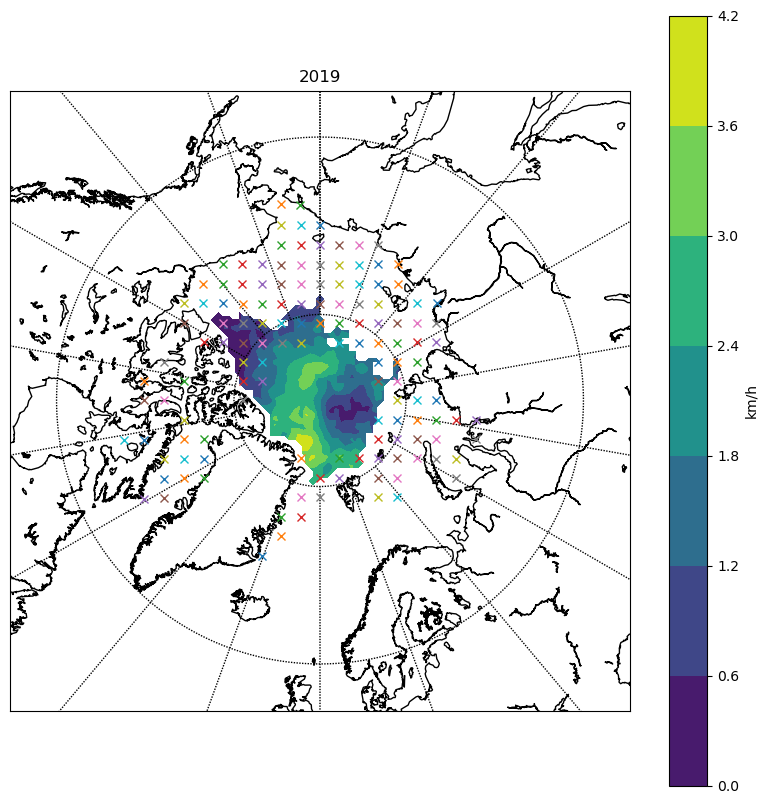

In [137]:
# don't plot if the spacing is lower than 50 (takes a while)
if SPACING >= 50:
    fig = plt.figure(figsize=(10,10))
    plt.set_cmap('viridis')
    m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

    m.drawcoastlines()
    #m.fillcontinents(color='0.1',lake_color='lightblue')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    #m.drawmapboundary(fill_color='lightblue')

    lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
    m.contourf(lon_map, lat_map, plotfield)
    
    # COMPUTED TRAJECTORY FROM Uice Vice
    for point_num in np.arange(0, num_points):
        a = np.ma.array(lons_df[point_num][0:1].values, mask=np.isnan(lons_df[point_num][0:1].values))
        b = np.ma.array(lats_df[point_num][0:1].values, mask=np.isnan(lats_df[point_num][0:1].values))
        lon_traj,lat_traj=m(a,b)
        #m.plot(lon_traj, lat_traj,'m')
        m.plot(lon_traj, lat_traj, marker='x')
        
    #plt.plot(lons[0][0], lats_df[0][0], 'ro')

    cbar=plt.colorbar()
    cbar.set_label('km/h')
    plt.title(f'{2019}')
    plt.show()


(array([53., 13., 16., 18., 12.,  8.,  6.,  1.,  2.,  4.]),
 array([  0.        ,  61.24998078, 122.49996157, 183.74994235,
        244.99992313, 306.24990391, 367.4998847 , 428.74986548,
        489.99984626, 551.24982704, 612.49980783]),
 <BarContainer object of 10 artists>)

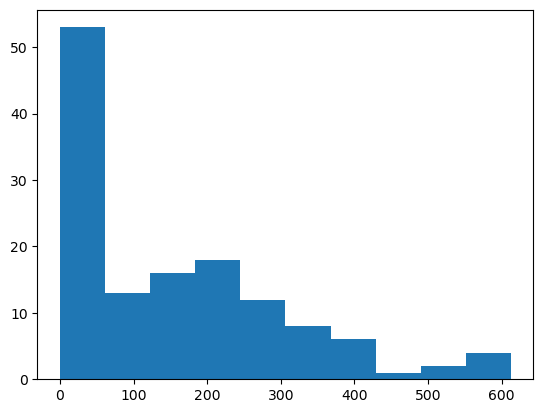

In [138]:
plt.hist(displacements)

Plot full trajectories:

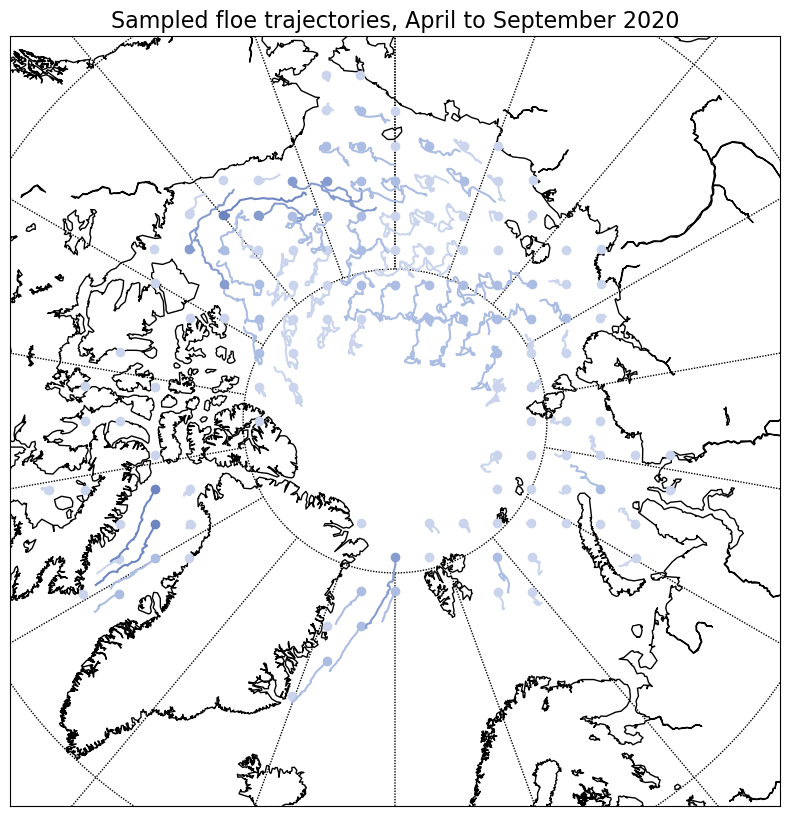

In [139]:
from geopy.distance import geodesic

# don't plot if the spacing is lower than 50 (takes a while)
if SPACING >= 50:
    fig = plt.figure(figsize=(10,10))
    plt.set_cmap('viridis')
    m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

    m.drawcoastlines()
    #m.fillcontinents(color='0.1',lake_color='lightblue')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    #m.drawmapboundary(fill_color='lightblue')

    lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
    #m.contourf(lon_map, lat_map, plotfield)

    # COMPUTED TRAJECTORY FROM Uice Vice
    colours = plt.get_cmap('tab20b')
    for point_num in np.arange(0, num_points):
        if displacements[point_num] < 200:
            col = '#cad4ed'
        elif displacements[point_num] >= 200 and displacements[point_num] < 400:
            col = '#acbde3'
        elif displacements[point_num] >= 400 and displacements[point_num] < 600:
            col = '#869ccf'
        elif displacements[point_num] >= 600 and displacements[point_num] < 800:
            col = '#6d86c2'
        elif displacements[point_num] >= 800 and displacements[point_num] < 1000:
            col = '#4260a8'
        else:
            col = '#081e52'
        
        a = np.ma.array(lons_df[point_num][:].values, mask=np.isnan(lons_df[point_num][:].values))
        b = np.ma.array(lats_df[point_num][:].values, mask=np.isnan(lats_df[point_num][:].values))
        lon_traj,lat_traj = m(a,b)
        #m.plot(lon_traj, lat_traj,'m')
        m.plot(lon_traj, lat_traj, color=col)
        
        a = np.ma.array(lons_df[point_num][0:1].values, mask=np.isnan(lons_df[point_num][0:1].values))
        b = np.ma.array(lats_df[point_num][0:1].values, mask=np.isnan(lats_df[point_num][0:1].values))
        lon_traj,lat_traj=m(a,b)
        #m.plot(lon_traj, lat_traj,'m')
        m.plot(lon_traj, lat_traj, marker='o', color=col)

    #plt.plot(lons[0][0], lats_df[0][0], 'ro')

    #cbar=plt.colorbar()
    #cbar.set_label('km/h')
    plt.title(f'Sampled floe trajectories, April to September {YEAR}', fontsize=16)
    plt.show()


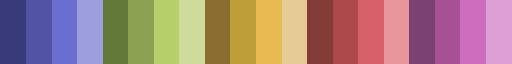

In [140]:
colours = plt.get_cmap('tab20b')
colours

### Map to MPF

In [141]:
#lats_df = pd.read_pickle('/home/htweedie/melt_ponds/data/forwarded_coords/2020_lats_forwarded_120_days_spacing_1.pkl')
#lons_df = pd.read_pickle('/home/htweedie/melt_ponds/data/forwarded_coords/2020_lons_forwarded_120_days_spacing_1.pkl')

In [142]:
# get final coords after forwarding and convert to correct coord system
final_lons = np.array(lons_df.tail(1)).ravel()
final_lats = np.array(lats_df.tail(1)).ravel()

x_sigma, y_sigma = WGS84toEASE2N(final_lons, final_lats)

/tmp/ipykernel_365137/1412458487.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


In [143]:
np.shape(x_sigma)

(133,)

/tmp/ipykernel_365137/1412458487.py:115: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Text(0.5, 1.0, 'Check that coords line up')

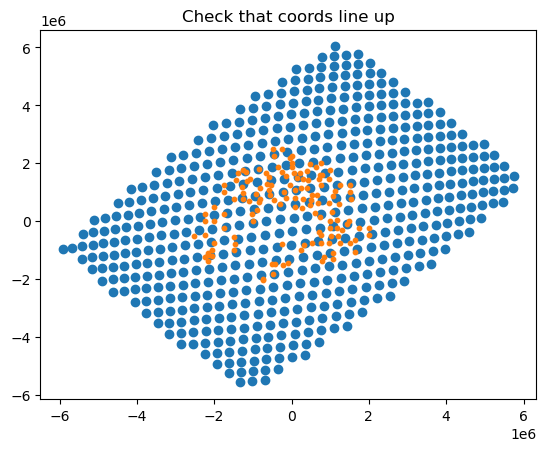

In [144]:
# retrieve MPF coordinates and check that they overlap with roughness coords
coord_fn = '/home/htweedie/melt_ponds/data/OLCI/olci/LongitudeLatitudeGrid-n12500-Arctic.h5'
coords = h5.File(coord_fn, 'r')
mpf_lon =  np.array(coords['Longitudes'])
mpf_lat = np.array(coords['Latitudes'])
x_mpf, y_mpf = WGS84toEASE2N(mpf_lon, mpf_lat)

# check that MPF and roughness coords overlap
plt.scatter(x_mpf.ravel()[::1000], y_mpf.ravel()[::1000])
plt.scatter(x_sigma, y_sigma, s=10)
plt.title('Check that coords line up')


Use a KD-tree to find all roughness (sigma) points within `max_radius` of each MPF point. Output is a list the size of the number of MPF points. Each element in this list contains a list of the indices of roughness points than are within the radius.

In [145]:
# Define a KD-tree using final lons and lats
tree = KDTree(list(zip(x_sigma.ravel(), y_sigma.ravel())))

# Query the tree to find all points within final_lons and final_lats grids
max_radius = 100000
#indices_within_grid = tree.query(list(zip(x_mpf.ravel(), y_mpf.ravel())), p=2, distance_upper_bound=max_radius)[1]
indices_within_grid = tree.query_ball_point(list(zip(x_mpf.ravel(), y_mpf.ravel())), r = max_radius)


In [146]:
np.shape(x_sigma)

(133,)

In [147]:
# calculate the mean of roughnesses within the radius for each MPF grid point
mean_sigma = np.zeros(len(indices_within_grid))
for i in range(len(indices_within_grid)):
    if len(indices_within_grid[i]) > 0:
        mean_sigma[i] = np.mean(sigma_cleaned[indices_within_grid[i]])

# convert 0s to nans
mean_sigma[mean_sigma==0] = np.nan


In [148]:
np.shape(mean_sigma)

(544768,)

/tmp/ipykernel_365137/466157228.py:3: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


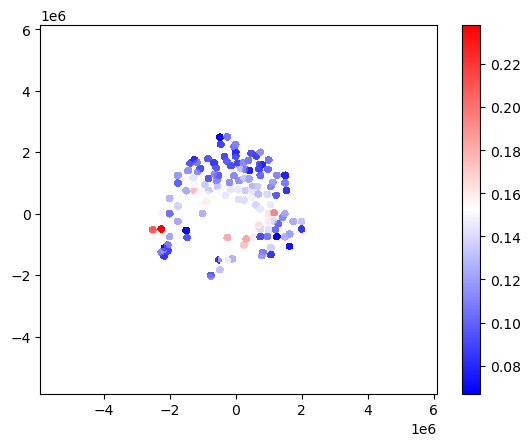

In [149]:
plt.set_cmap('bwr')
plt.pcolor(x_mpf, y_mpf, mean_sigma.reshape(896, 608))
plt.colorbar()


### Predict MPF

In [150]:
from scipy.interpolate import griddata

def predict_mpf(SIR, R0, l, tau, hnet):
    '''
    Predicts meltpond fraction given an input SIR, based on the model by Landy et al, 2015.
    '''
    R = R0 * np.exp(-l * SIR) + tau
    return (1 - np.exp(-R * hnet))

def interpolate_to_MISR(x_in, y_in, data, x_out, y_out):
    '''
    Interpolates data of the shape x_in, y_in to the shape of x_out, y_out.
    
    Params:
        data: the data to be interpolated
        x_in, y_in: the shape of the data to be interpolated
        
    Returns:
        x_out, y_out: the shape to which the data will be interpolated'''
    return griddata((x_in.ravel(), y_in.ravel()), data.ravel( ), (x_out.ravel(), y_out.ravel()), 'nearest').reshape(8000,8000) 


In [151]:
R0 = 65.43
L = 16.14
TAU = 5.15
HNET = 0.025    # hnet between 20 and 40mm from Landy

forwarded_pred_mpf = predict_mpf(mean_sigma, R0, L, TAU, HNET)

proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
mpf_lon, mpf_lat = pyproj.transform(proj_EASE2N, proj_WGS84,x_mpf, y_mpf)

/tmp/ipykernel_365137/191670684.py:10: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mpf_lon, mpf_lat = pyproj.transform(proj_EASE2N, proj_WGS84,x_mpf, y_mpf)


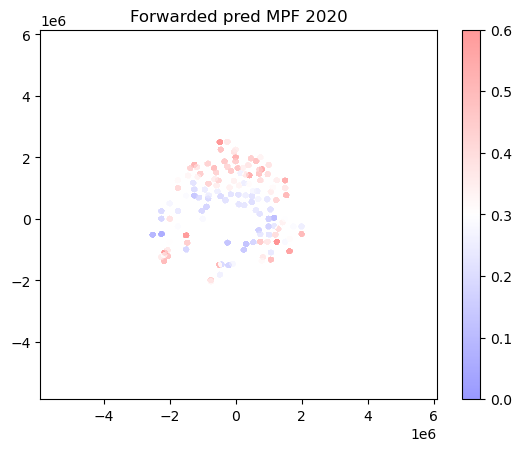

In [152]:
plt.set_cmap('bwr')
plt.pcolormesh(x_mpf, y_mpf, forwarded_pred_mpf.reshape(896, 608), vmin=0, vmax=0.6,alpha=0.4)
#plt.pcolormesh(x_mpf, y_mpf, mpf, vmin=0, vmax=0.6)
plt.title('Forwarded pred MPF 2020')
plt.colorbar()
plt.show()



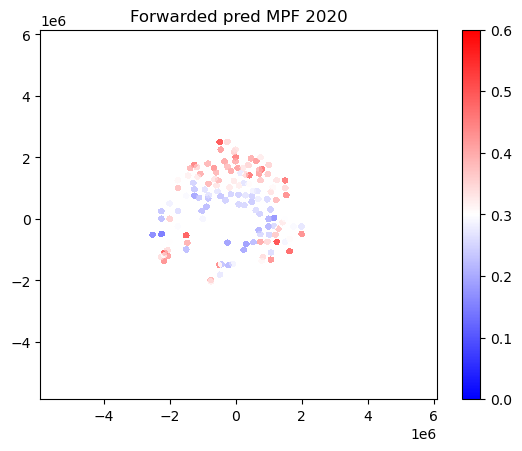

In [153]:
plt.set_cmap('bwr')
plt.pcolormesh(x_mpf, y_mpf, forwarded_pred_mpf.reshape(896, 608), vmin=0, vmax=0.6)
plt.title('Forwarded pred MPF 2020')
plt.colorbar()
plt.show()

In [154]:
fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/2020/data/mpd1_20200815.nc'
ds = xr.open_dataset(fn)
mpf = ds['mpf']

In [155]:
mpf.shape

(896, 608)

In [156]:
mpf_pred=forwarded_pred_mpf.reshape(896, 608)

Plot MPF timeseries for one point:

Text(0, 0.5, 'MPF')

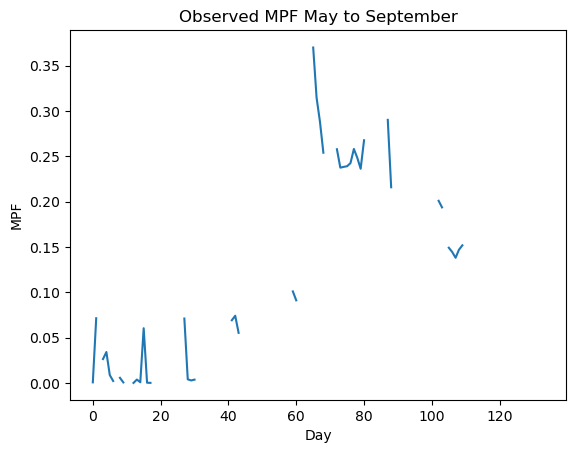

In [157]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

MONTHS = ('05', '06', '07', '08', '09')
YEAR = 2020
POINT_X, POINT_Y = 300, 450

# configure list of dates for which files will be loaded
dates = []
for month in MONTHS:
    if month in ('09','04','06','11'):
        n_days = 30
    elif month == '02':
        n_days = 28
    else:
        n_days = 31

    for day in range(n_days):
        # configure day string
        day += 1
        if day < 10:
            day_str = f'0{day}'
        else:
            day_str = str(day)

        dates.append(f'{YEAR}{month}{day_str}')
    
# load files and extract data for specified point
mpf_timeseries = []
for date in dates:
    fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}/data/mpd1_{date}.nc'
    ds = xr.open_dataset(fn)
    mpf = np.asarray(ds['mpf'])
    mpf_timeseries.append(mpf[POINT_Y, POINT_X])


plt.plot(mpf_timeseries)
plt.title('Observed MPF May to September')
plt.xlabel('Day')
plt.ylabel('MPF')


Plot mean MPF timeseries for a subset of points:

Text(0, 0.5, 'MPF')

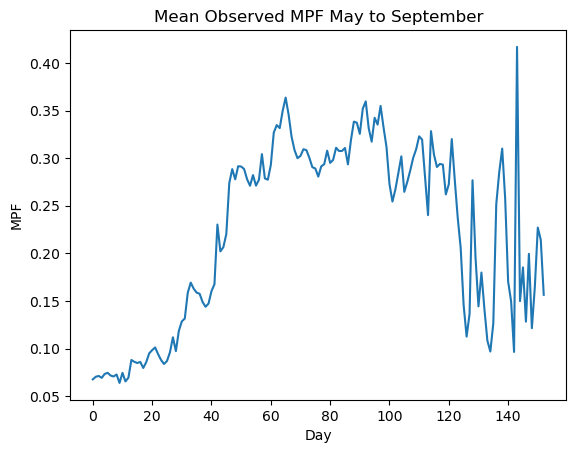

In [158]:
MONTHS = ('05', '06', '07', '08', '09')
YEAR = 2020
#SPACING = 20

# configure list of dates for which files will be loaded
dates = []
for month in MONTHS:
    if month in ('09','04','06','11'):
        n_days = 30
    elif month == '02':
        n_days = 28
    else:
        n_days = 31

    for day in range(n_days):
        # configure day string
        day += 1
        if day < 10:
            day_str = f'0{day}'
        else:
            day_str = str(day)

        dates.append(f'{YEAR}{month}{day_str}')
    
# load files and extract data for specified point
mpf_timeseries_mean = []
mpf_timeseries_max = []
mpf_timeseries_min = []
for date in dates:
    fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}/data/mpd1_{date}.nc'
    ds = xr.open_dataset(fn)
    mpf = np.asarray(ds['mpf'])
    mpf_timeseries_mean.append(np.nanmean(mpf))
    mpf_timeseries_max.append(np.nanmax(mpf))
    mpf_timeseries_min.append(np.nanmin(mpf))

plt.plot(mpf_timeseries_mean)
plt.title('Mean Observed MPF May to September')
plt.xlabel('Day')
plt.ylabel('MPF')


Text(0, 0.5, 'MPF')

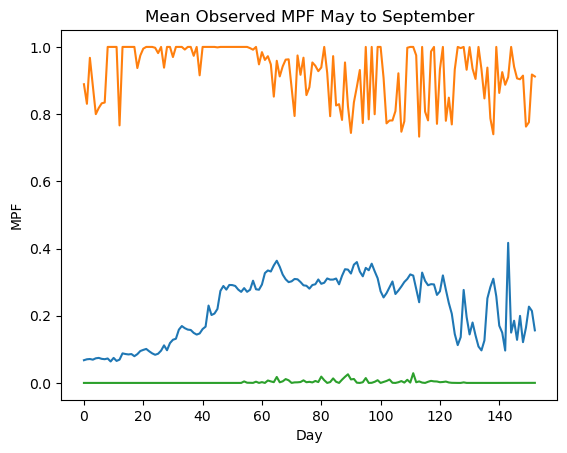

In [159]:
plt.plot(mpf_timeseries_mean)
plt.plot(mpf_timeseries_max)
plt.plot(mpf_timeseries_min)
plt.title('Mean Observed MPF May to September')
plt.xlabel('Day')
plt.ylabel('MPF')